# Set up 

In [1]:
import numpy as np
import os
import sys

# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9) #m3
Iyy = 6610.17475482 * 10 ** (-6)  #kgm2
hull_surface_area = 0.05 #m2

r_xi = -111.76 * 10 ** (-3)
r_zi = 0.722 * 10 ** (-3)

r_xh = -0.01
r_zh = 0.01

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10 ** (-3)
r_zt = -35.18 * 10 ** (-3)

rho = 1000

# Aero foil parameters
AR = 2.61 #aspect ratio
area = 0.025 #Surface area
C_L_a = 0.1/np.deg2rad(1)
C_L_alpha_offset = 0.5
C_D_0 = 0.02



## Initialize the models

In [3]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]),10,np.deg2rad(30))
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5),AR,area,C_L_a,C_L_alpha_offset,C_D_0)
hullForce = HullForce(hull_surface_area,np.array([r_xh,r_zh]))

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])



# Solve Equilibrium Point

### A- Solve by minimizing square sum of EOM

In [ ]:
#Find equilibrium by minimizing 3D vector of Forces and moment
lb_tow_force, ub_tow_force = np.array([0, 2000])
lb_delta_t, ub_delta_t = np.deg2rad(np.array([0, 70]))
lb_delta_i, ub_delta_i = np.deg2rad(np.array([-20, 10]))
lb_pitch_angle, ub_pitch_angle = np.deg2rad(np.array([-8, -2]))


sim.bounds[0] =  np.array([lb_pitch_angle, ub_pitch_angle])  #(np.deg2rad((-10,10))) # pitch angle bounds
sim.bounds[1] =  np.array([lb_delta_t, ub_delta_t])          #(np.deg2rad((0,100)))  # towing angle bounds
sim.bounds[3] =  np.array([lb_delta_i, ub_delta_i])          #(np.deg2rad((-20,10))) # delta i bounds


results = sim.solve_equilibrium_state_sqrt(2)


#Solve forward euler
#initial_state = np.array([0, 0, results.x[0], 2, 0, 0, 0, 0, 0]) #Set pitch angle to equilibrium value
#sim.sim = sim.simulate_forward_euler(1000,0.01,initial_state)

Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH


### B- Minimize F_T

In [ ]:
#Find equilibrium by constraining forces/moment to zero and solve for minimum towing force
results = sim.solve_equilibrium_state_min_FT(2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 96.54712607422559
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -2.00           degrees   
Delta_t         15.98           degrees   
Towing Force    96.55           N         
Delta_i         1.96            degrees   
----------------------
Fx constraint   0.00            N         
Fz constraint   -0.00           N         
My constraint   0.00            Nm        
Objective Function Value: 96.54712607422559
Optimization successful!


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


### C- LS 

In [6]:
#Find equilibrium by minimizing Forces and moment individually using least squares
results_LS = sim.solve_equilibrium_state_LS(2)

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -4.75           degrees   
Delta_t         14.92           degrees   
Towing Force    95.78           N         
Delta_i         5.14            degrees   
----------------------
Fx:             0.00           N         
Fz:             -0.00          N         
My:             0.00           Nm        
Residual Norm: 0.000000
Optimization successful!


## Equilibrium points wrt pitch angle


Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -7.00           degrees   
Delta_t         14.06           degrees   
Towing Force    95.21           N         
Delta_i         7.72            degrees   
----------------------
Fx:             0.00           N         
Fz:             -0.00          N         
My:             0.00           Nm        
Residual Norm: 0.000000
Optimization successful!
Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -5.44           degrees   
Delta_t         14.65           degrees   
Towing Force    95.60           N         
Delta_i         5.93            degrees   
----------------------
Fx:             -0.00          N         
Fz:             0.00           N         
My:             -0.00          Nm        
Residual Norm: 0.000000
Optimization successful!
Optimization Results:
----------------

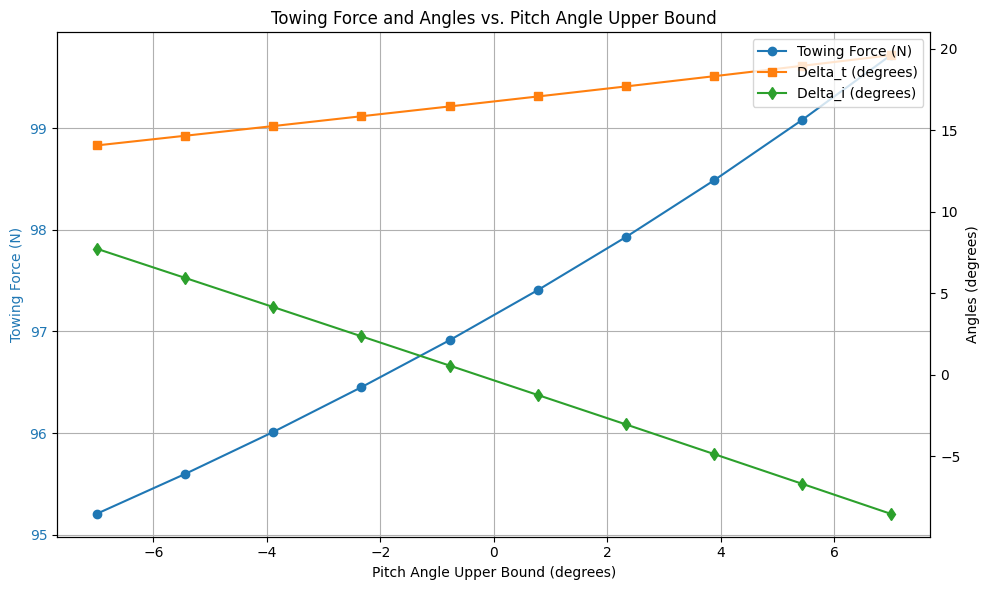

In [7]:
import matplotlib.pyplot as plt

# Generate pitch angle upper bounds (in radians)
pitch_angle_upper_bounds = np.linspace(-7, 7, 10)  # 10 points from -7 to 7 degrees

# Initialize arrays for results
towForces = np.zeros_like(pitch_angle_upper_bounds)
delta_ts = np.zeros_like(pitch_angle_upper_bounds)
delta_is = np.zeros_like(pitch_angle_upper_bounds)

# Run the simulation for each upper bound
for i, pitch_angle_ub in enumerate(pitch_angle_upper_bounds):
    sim.ub_pitch_angle = np.deg2rad(pitch_angle_ub)  # Convert to radians
    sim.lb_pitch_angle = np.deg2rad(pitch_angle_ub - 0.01)  # Lower bound in radians
    sim.bounds[0] = (sim.lb_pitch_angle, sim.ub_pitch_angle)
    result_LS = sim.solve_equilibrium_state_LS(2)  # Simulate and retrieve results

    # Store results
    delta_ts[i] = np.rad2deg(result_LS[1])  # Convert to degrees
    towForces[i] = result_LS[2]  # Force in N
    delta_is[i] = np.rad2deg(result_LS[3])  # Convert to degrees

# Create the figure and twin axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot towing force on the primary y-axis
ax1.plot(pitch_angle_upper_bounds, towForces, 'o-', color='tab:blue', label='Towing Force (N)')
ax1.set_xlabel('Pitch Angle Upper Bound (degrees)')
ax1.set_ylabel('Towing Force (N)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot delta_t and delta_i on the secondary y-axis
ax2.plot(pitch_angle_upper_bounds, delta_ts, 's-', color='tab:orange', label='Delta_t (degrees)')
ax2.plot(pitch_angle_upper_bounds, delta_is, 'd-', color='tab:green', label='Delta_i (degrees)')

ax2.set_ylabel('Angles (degrees)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Adjust layout and show the plot
plt.title('Towing Force and Angles vs. Pitch Angle Upper Bound')
plt.tight_layout()
plt.show()


# Simulations

### A -Forward Euler

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     7.00            degrees   
Delta_t         19.59           degrees   
Towing Force    99.72           N         
Delta_i         -8.54           degrees   
----------------------
Fx:             0.00           N         
Fz:             0.00           N         
My:             -0.00          Nm        
Residual Norm: 0.000000
Optimization successful!


../model/Force.py:69: RuntimeWarning: overflow encountered in double_scalars
  V = np.sqrt((u + q * r_z)**2 + (w - q * r_x)**2)
../model/Force.py:47: RuntimeWarning: overflow encountered in double_scalars
  V = np.sqrt((u + q * r_z)**2 + (w - q * r_x)**2)
../model/RigidBody.py:52: RuntimeWarning: invalid value encountered in double_scalars
  total_force_x = -(self.mass * 9.81 - self.buoyancy) *  np.sin(theta) \
../model/RigidBody.py:83: RuntimeWarning: invalid value encountered in double_scalars
  +f.location[1] * (-f.magnitude[0] * np.cos(f.alpha_i) + f.magnitude[1] * np.sin(f.alpha_i))) \
../model/Simulation.py:221: RuntimeWarning: overflow encountered in double_scalars
  ax_body = total_force[0] / self.rigidbody.mass + self.sim.pitch_rate[i - 1] * self.sim.bf_velocity[i - 1, 1]
../model/Simulation.py:222: RuntimeWarning: overflow encountered in double_scalars
  az_body = total_force[1] / self.rigidbody.mass - self.sim.pitch_rate[i - 1] * self.sim.bf_velocity[i - 1, 0]


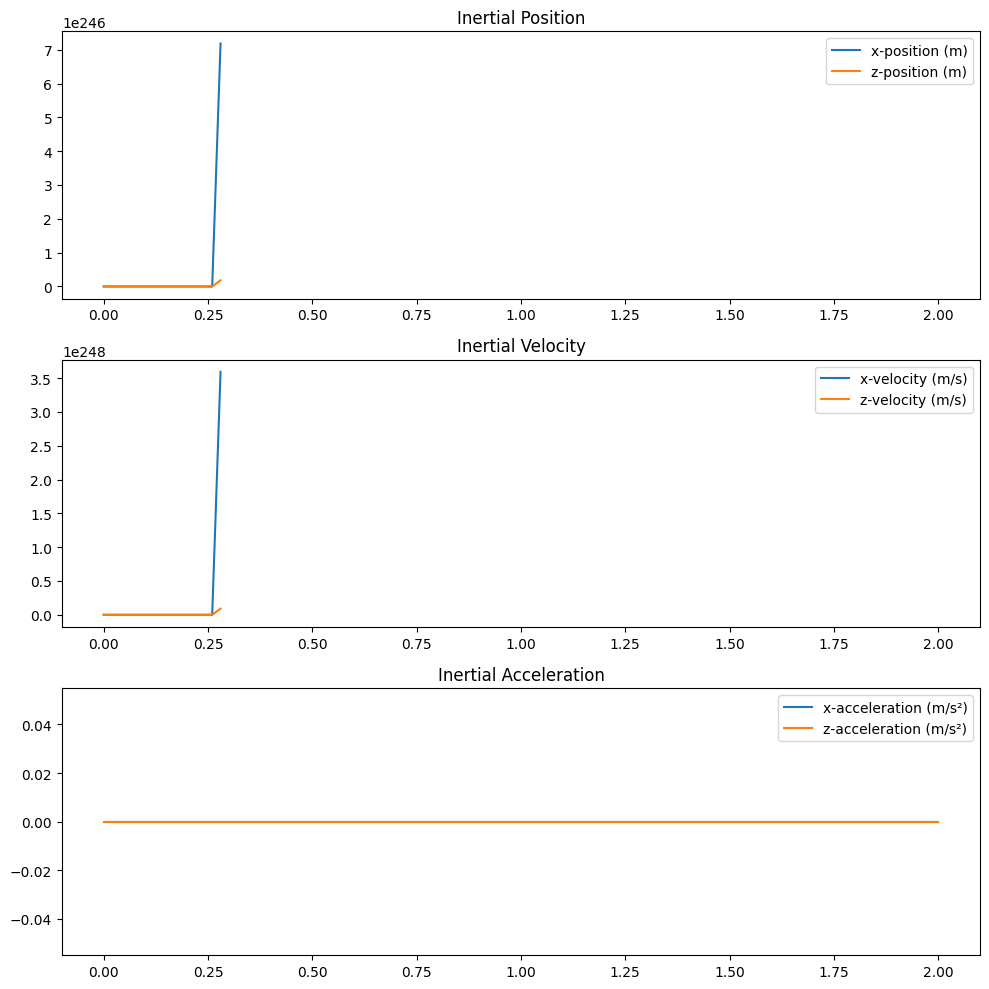

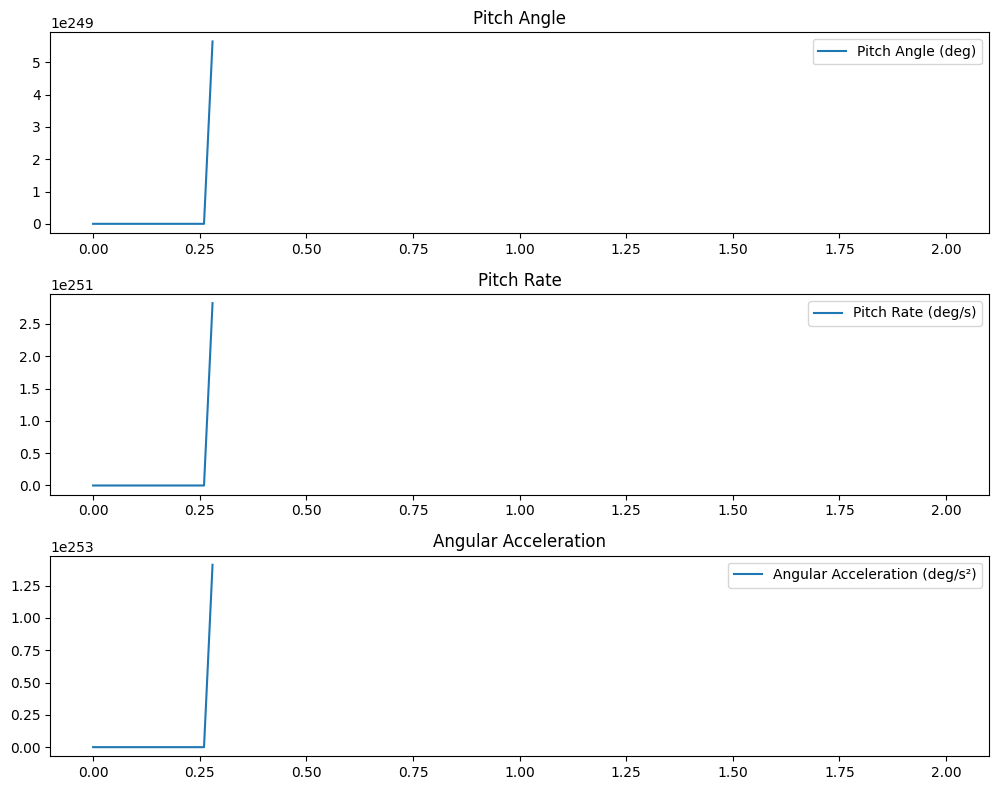

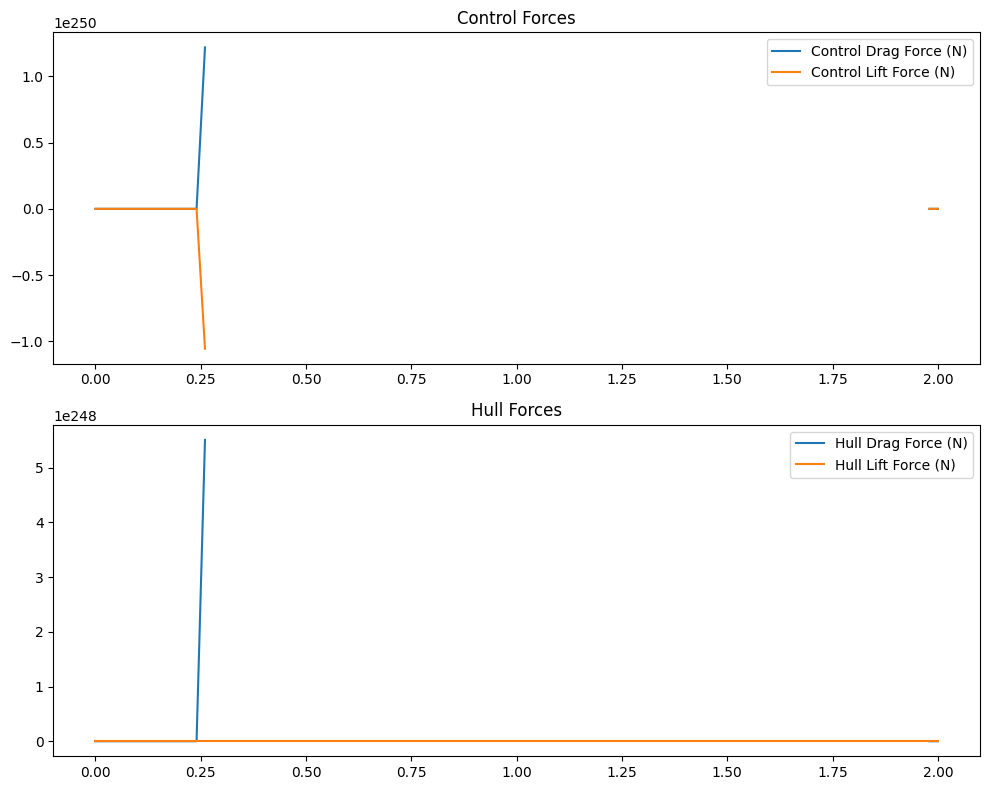

In [8]:
initial_state = np.zeros(9)
initial_state[2] = result_LS[0]
initial_state[3] = 2

results_LS = sim.solve_equilibrium_state_LS(2)
sim_result = sim.simulate_forward_euler(100, 0.01, initial_state)
sim_result.plot_simulation_results()

### B- RK45 solver

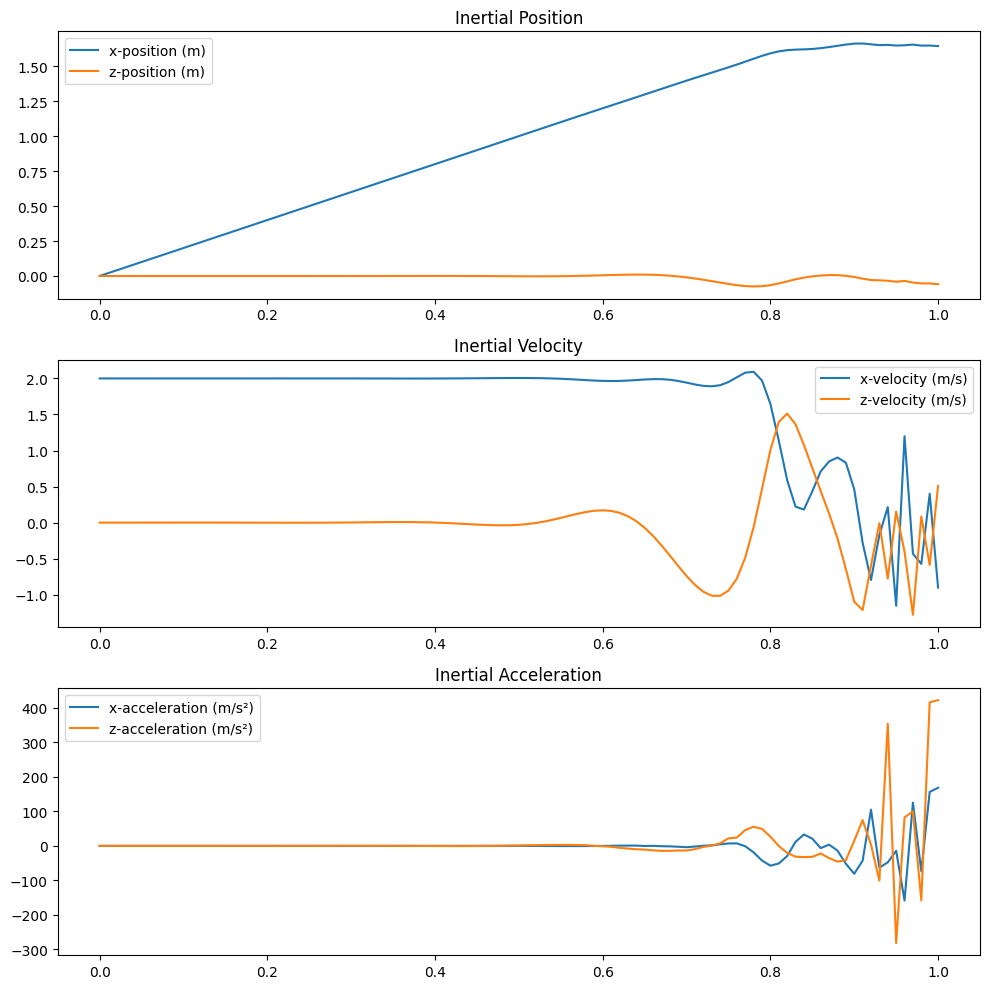

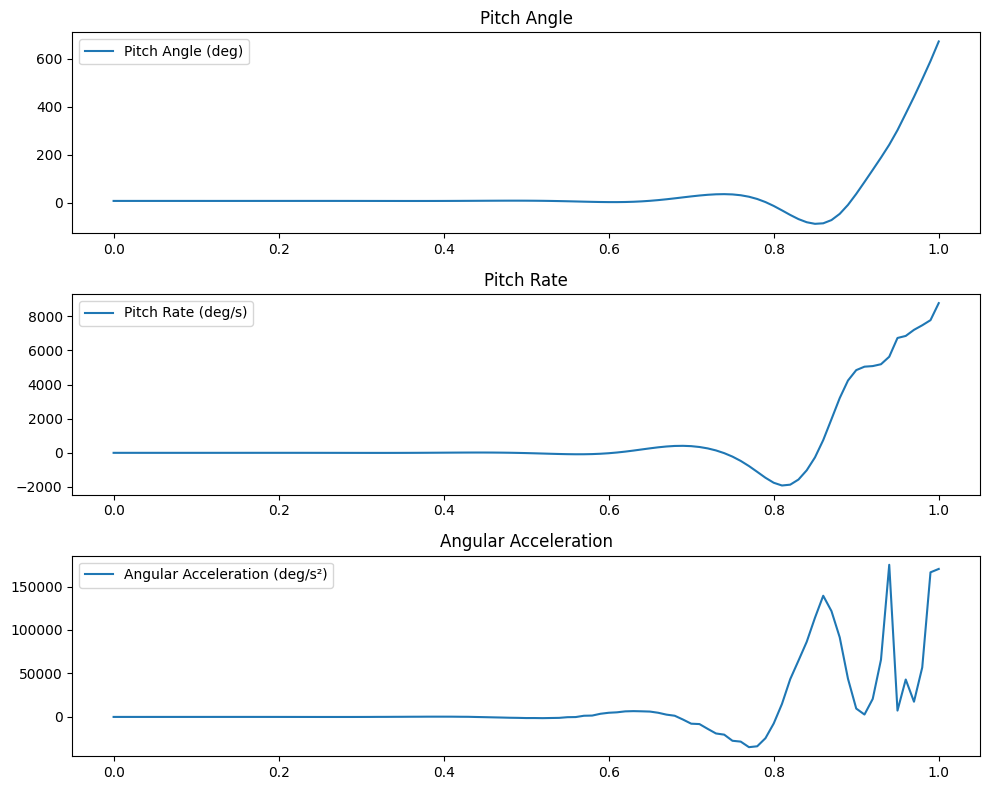

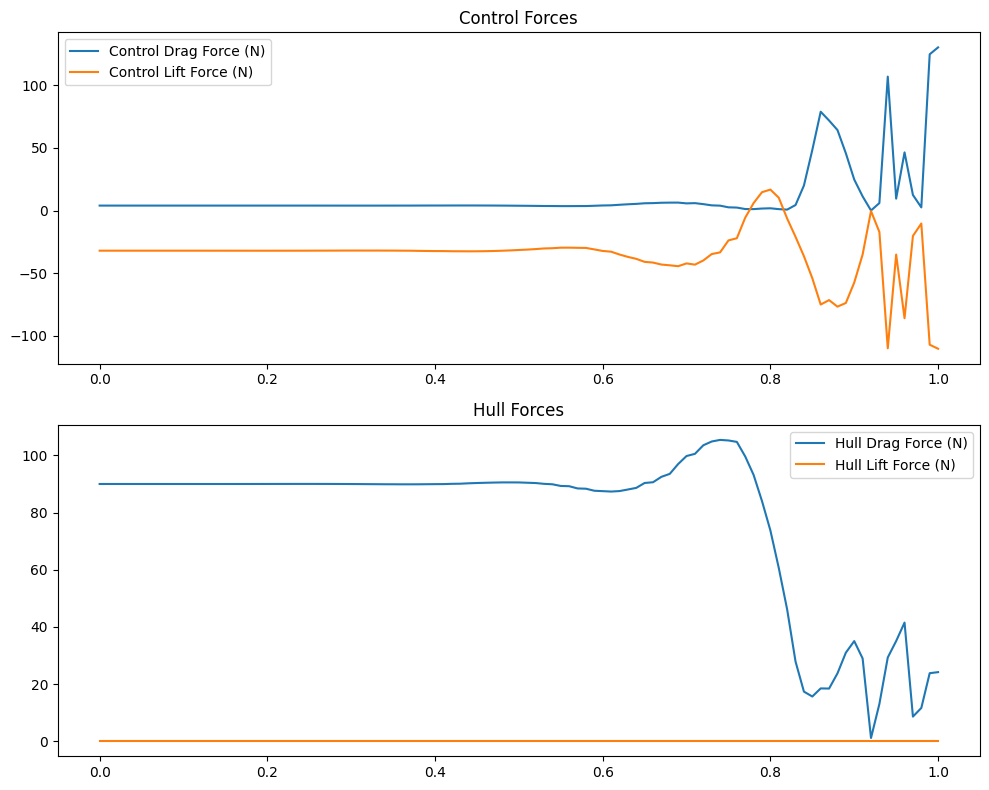

In [9]:
sim_result_ivp, solution = sim.simulate_solve_ivp(100, 0.01, initial_state[:6])
sim_result_ivp.plot_simulation_results()

# Jacobian Calculation

In [10]:
velocity = 2
results_LS = sim.solve_equilibrium_state_LS(velocity)
# sim.calculate_jacobian()
pitch_angle = results_LS[0]


Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     7.00            degrees   
Delta_t         19.59           degrees   
Towing Force    99.72           N         
Delta_i         -8.54           degrees   
----------------------
Fx:             0.00           N         
Fz:             0.00           N         
My:             -0.00          Nm        
Residual Norm: 0.000000
Optimization successful!


In [11]:
jacobian = sim.calculate_jacobian(velocity, pitch_angle, 1e-3)
eigs= np.linalg.eig(jacobian)
print(eigs[0])

[  0.         +0.j           0.         +0.j
 -12.83911455+25.82581606j -12.83911455-25.82581606j
 178.88386351 +0.j         104.82391518 +0.j        ]


In [12]:
jacobian = sim.calculate_jacobian(velocity, pitch_angle, 1e-6)
eigs= np.linalg.eig(jacobian)
print(eigs[0])

[  0.         +0.j           0.         +0.j
 -12.84292866+25.84325767j -12.84292866-25.84325767j
 178.89846608 +0.j         104.80836348 +0.j        ]


# Perturbation Simulation

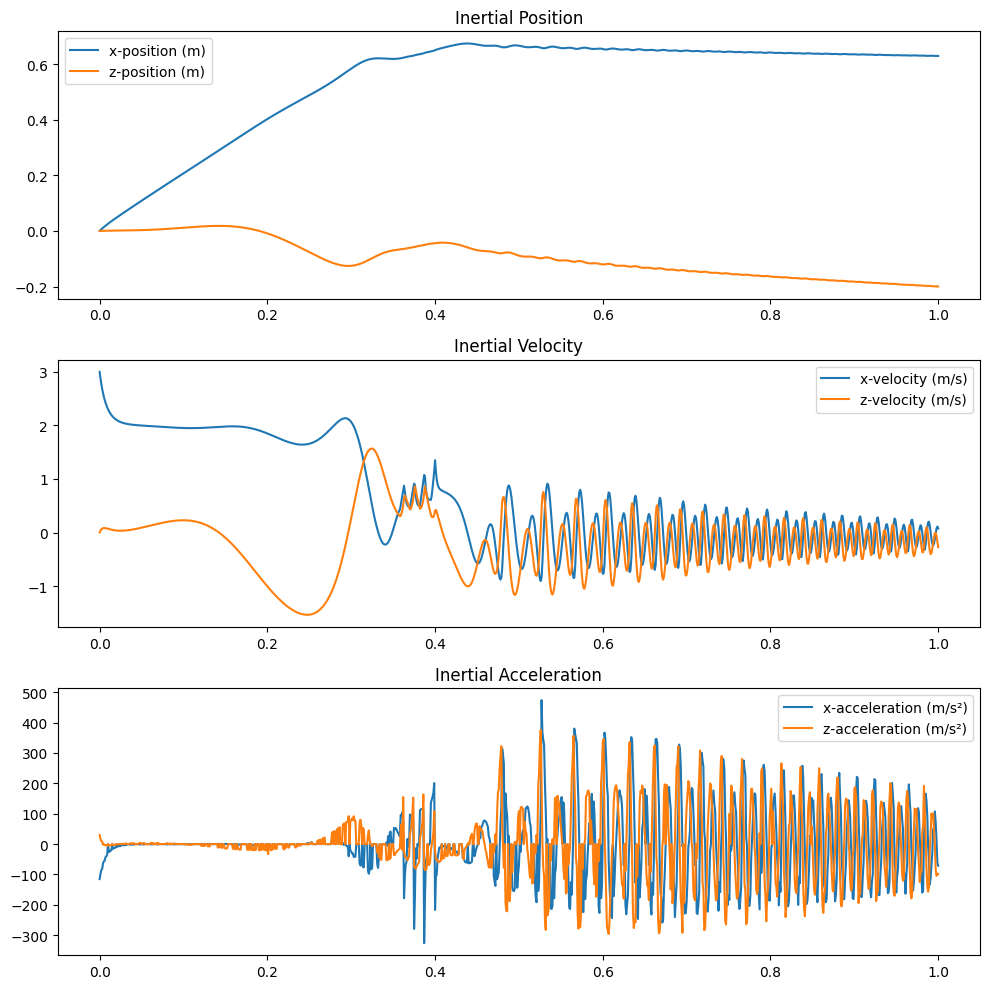

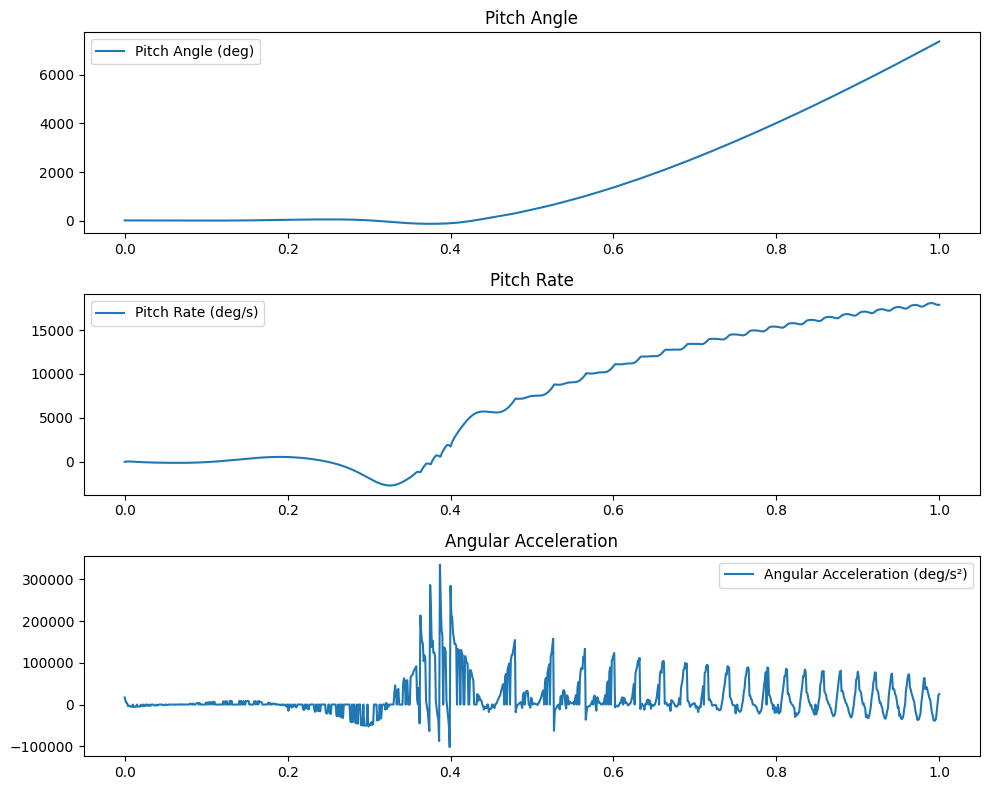

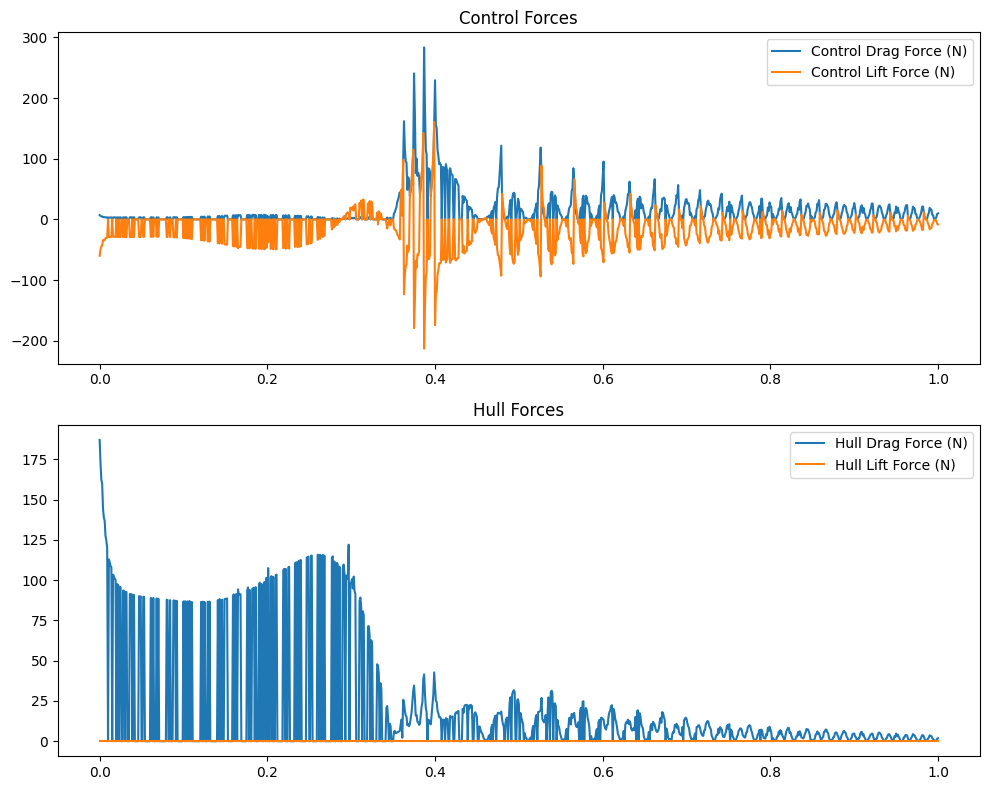

In [13]:
perturbed_state = np.copy(initial_state[:6]) 
perturbed_state[3] += 1
sim_result_ivp, solution = sim.simulate_solve_ivp(1000, 0.001, perturbed_state)
sim_result_ivp.plot_simulation_results()